In [1]:
import sys
import scipy.io
import scipy.signal as sig
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import os

In [2]:
dataset = pd.read_pickle("CinC2017Data/database.pk")

In [3]:
def adaptive_gain_norm(x, w):
    x_mean_sub = np.pad(x - x.mean(), int((w-1)/2), "reflect")
    window = np.ones(w)
    sigma_square = np.convolve(x_mean_sub**2, window, mode="valid")/w
    gain = 1/np.sqrt(sigma_square)

    return x * gain

In [3]:
dataset["length"] = dataset["data"].map(lambda arr: arr.shape[-1])
dataset["data"] = dataset["data"].map(lambda d: d[0])

In [4]:
# select only the 30s length records
dataset = dataset[dataset["length"] == 9000]

In [5]:
# dataset["data"] = dataset["data"].map(lambda d: adaptive_gain_norm(d, 501))

In [2]:
from enum import Enum

class DiagEnum(Enum):
    AF = 1
    CannotExcludePathology = 2
    NoAF = 3
    PoorQuality = 4
    ScreeningFailure = 5
    Undecided = 6
    ReviewersDisagree = -1

feas2_path = r"D:\2022_23_DSiromani\Feas2"

feas2_pt_data = pd.read_csv(os.path.join(feas2_path, "pt_data_anon.csv"))
feas2_ecg_data = pd.read_pickle(os.path.join(feas2_path, r"ECGs\filtered_dataframe.pk"))

print(feas2_ecg_data.head())

   ptID   age         ptDiag          ptDiagRev1     ptDiagRev2  \
0     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   
1     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   
2     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   
3     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   
4     1  79.0  DiagEnum.NoAF  DiagEnum.Undecided  DiagEnum.NoAF   

           ptDiagRev3  cardRev            measDiag        measDiagRev1  \
0  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   
1  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   
2  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   
3  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   
4  DiagEnum.Undecided        1  DiagEnum.Undecided  DiagEnum.Undecided   

         measDiagRev2  ...  poss_AF_tag not_tagged  not_tagged_ign_wide_qrs  \
0  DiagEnum.Undecided  ...            0          1                       

In [3]:
feas2_ecg_data["class_index"] = feas2_ecg_data["measDiag"].map(lambda x: int(x == DiagEnum.PoorQuality))

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [6]:
import torch.nn as nn
import torch

In [7]:
# Check cuda
print(torch.cuda.is_available())

True


In [8]:
# Now define a model
class CVAE(nn.Module):

    def __init__(self):
        super(CVAE, self).__init__()

        self.conv_section1 = nn.Sequential(
            nn.Conv1d(1, 16, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 16, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )

        self.conv_section2 = nn.Sequential(
            nn.Conv1d(16, 16, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Conv1d(16, 16, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )

        self.conv_section3 = nn.Sequential(
            nn.Conv1d(16, 32, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 32, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )

        self.conv_section4 = nn.Sequential(
            nn.Conv1d(32, 48, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(48),
            nn.Conv1d(48, 48, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(48)
        )

        self.conv_section5 = nn.Sequential(
            nn.Conv1d(48, 64, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.conv_section6 = nn.Sequential(
            nn.Conv1d(64, 64, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, 19, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.conv_section7 = nn.Sequential(
            nn.Conv1d(64, 80, 9, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(80),
            nn.Conv1d(80, 80, 9, padding='same'),
            nn.ReLU(),
            nn.BatchNorm1d(80)
        )

        self.encoder_linear = nn.Linear(5120, 120)
        self.decoder_linear = nn.Linear(60, 5120)
        self.decoder_batchnorm = nn.BatchNorm1d(5120)

        self.transconv_section1 = nn.Sequential(
            nn.ConvTranspose1d(16, 1, 19, padding=9, stride=1),
        )

        self.transconv_section2 = nn.Sequential(
            nn.ConvTranspose1d(16, 16, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),
        )

        self.transconv_section3 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),
        )

        self.transconv_section4 = nn.Sequential(
            nn.ConvTranspose1d(48, 32, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        self.transconv_section5 = nn.Sequential(
            nn.ConvTranspose1d(64, 48, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(48),
        )

        self.transconv_section6 = nn.Sequential(
            nn.ConvTranspose1d(64, 64, 20, padding=9, stride=2),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.transconv_section7 = nn.Sequential(
            nn.ConvTranspose1d(80, 64, 9, padding=4, stride=1),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.dropout = nn.Dropout()

    def encode(self, x):
        # [1, 2048]
        x = self.conv_section1(x)
        x = nn.functional.max_pool1d(x, 2)

        # [16, 1024]
        x = self.conv_section2(x)
        x = nn.functional.max_pool1d(x, 2)

        # [32, 512]
        x = self.conv_section3(x)
        x = nn.functional.max_pool1d(x, 2)

        # [48, 256]
        x = self.conv_section4(x)
        x = nn.functional.max_pool1d(x, 2)

        # [64, 128]
        x = self.conv_section5(x)
        x = nn.functional.max_pool1d(x, 2)

        # [64, 64]
        x = self.conv_section6(x)

        # [64, 64]
        x = self.conv_section7(x)

        # [80, 64]
        x = torch.flatten(x, -2)

        # [5120]
        x = self.encoder_linear(x)
        return x

    def decode(self, z):
        # [60]
        z = self.decoder_linear(z)
        z = self.decoder_batchnorm(z)
        z = torch.nn.functional.relu(z)

        # [5120]
        z = torch.reshape(z, (-1, 80, 64))
        # [80, 64]
        z = self.transconv_section7(z)
        # print(z.shape)
        # [64, 64]
        z = self.transconv_section6(z)
        # print(z.shape)
        # [64, 64]
        z = self.transconv_section5(z)
        # print(z.shape)
        # [64, 128]
        z = self.transconv_section4(z)
        # print(z.shape)
        # [48, 256]
        z = self.transconv_section3(z)
        # print(z.shape)
        # [32, 512]
        z = self.transconv_section2(z)
        # print(z.shape)
        # [16, 1024]
        z = self.transconv_section1(z)
        # print(z.shape)
        # [1, 2048]
        return z


    def forward(self, x):
        batch_size = x.shape[0]
        device = x.device

        z_dist = self.encode(x)

        # Sample from the latent distribution
        z = torch.randn((batch_size, 60)).to(device) * torch.abs(z_dist[:, 60:]) + z_dist[:, :60]

        x = self.decode(z)

        return x, z_dist

In [9]:
# Onehot encoding
from torch.utils.data import Dataset, DataLoader

def generate_onehot(c):
    if c == "N":
        return np.array([1, 0, 0, 0])
    if c == "O":
        return np.array([0, 1, 0, 0])
    if c == "A":
        return np.array([0, 0, 1, 0])
    if c == "~":
        return np.array([0, 0, 0, 1])

def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 0
    if c == "A":
        return 0
    if c == "~":
        return 1

# dataset["onehot"] = dataset["class"].map(generate_onehot)
# dataset["class_index"] = dataset["class"].map(generate_index)

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"]
        y = row["class_index"]

        return X, y

In [10]:
def split_to_segments(dataset, new_len, orig_len, overlap=0):
    sections = []

    num_sections = orig_len // new_len
    for _, series in dataset.iterrows():
        for i in range(num_sections):
            data = series["data"][i*new_len: (i+1)*new_len]
            label = series["class_index"]
            sections.append({"data": data, "class_index": label})

    return pd.DataFrame(sections)

In [13]:
# For CinC data

train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, stratify=dataset["class_index"])

# Normalise the data
train_dataset["data"] = (train_dataset["data"] - train_dataset["data"].map(lambda x: x.mean()))/train_dataset["data"].map(lambda x: x.std())
test_dataset["data"] = (test_dataset["data"] - test_dataset["data"].map(lambda x: x.mean()))/test_dataset["data"].map(lambda x: x.std())

print(train_dataset["data"].map(lambda x: x.mean()))
print(train_dataset["data"].map(lambda x: x.std()))

torch_dataset_train = Dataset(split_to_segments(train_dataset[train_dataset["class_index"] == 0], 2048, 9000, 0))
torch_dataset_test = Dataset(split_to_segments(test_dataset[test_dataset["class_index"] == 0], 2048, 9000, 0))

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

A00491    9.473903e-18
A08427    1.657933e-17
A00738    0.000000e+00
A07861   -2.052679e-17
A03273   -1.815831e-17
              ...     
A05015   -1.342136e-17
A02962    9.868649e-18
A07163   -2.447425e-17
A00448    1.421085e-17
A00570   -1.736882e-17
Name: data, Length: 5080, dtype: float64
A00491    1.0
A08427    1.0
A00738    1.0
A07861    1.0
A03273    1.0
         ... 
A05015    1.0
A02962    1.0
A07163    1.0
A00448    1.0
A00570    1.0
Name: data, Length: 5080, dtype: float64


In [32]:
# For SAFER data
# Split train and test data according to each patient
test_frac = 0.2

feas2_pt_data["noLQrecs"] = feas2_pt_data["noRecs"] - feas2_pt_data["noHQrecs"]
train_patients = []
test_patients = []

for val, df in feas2_pt_data.groupby("noLQrecs"):
    print(f"processing {val}")
    test = df.sample(frac=test_frac)
    test_patients.append(test)
    train_patients.append(df[~df["ptID"].isin(test["ptID"])])

train_pt_df = pd.concat(train_patients)
test_pt_df = pd.concat(test_patients)

print(f"Test high quality: {test_pt_df['noHQrecs'].sum()} low quality: {test_pt_df['noLQrecs'].sum()} ")
print(f"Train high quality: {train_pt_df['noHQrecs'].sum()} low quality: {train_pt_df['noLQrecs'].sum()} ")

# get ECG datasets
train_dataset = feas2_ecg_data[feas2_ecg_data["ptID"].isin(train_pt_df["ptID"])]
test_dataset = feas2_ecg_data[feas2_ecg_data["ptID"].isin(test_pt_df["ptID"])]

# Normalise
train_dataset["data"] = (train_dataset["data"] - train_dataset["data"].map(lambda x: x.mean()))/train_dataset["data"].map(lambda x: x.std())
test_dataset["data"] = (test_dataset["data"] - test_dataset["data"].map(lambda x: x.mean()))/test_dataset["data"].map(lambda x: x.std())

# Train only on clean samples, test on both
torch_dataset_train = Dataset(split_to_segments(train_dataset[train_dataset["class_index"] == 0], 2048, 9000, 0))
torch_dataset_test = Dataset(split_to_segments(test_dataset, 2048, 9000, 0))

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

processing 0
processing 1
processing 2
processing 3
processing 4
processing 5
processing 6
processing 7
processing 8
processing 9
processing 10
processing 11
processing 12
processing 13
processing 14
processing 15
processing 16
processing 17
processing 21
processing 26
processing 27
processing 33
Test high quality: 4537 low quality: 101 
Train high quality: 18142 low quality: 479 


C:\Users\daniel\AppData\Local\Temp\ipykernel_18376\2162503662.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset["data"] = (train_dataset["data"] - train_dataset["data"].map(lambda x: x.mean()))/train_dataset["data"].map(lambda x: x.std())
C:\Users\daniel\AppData\Local\Temp\ipykernel_18376\2162503662.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset["data"] = (test_dataset["data"] - test_dataset["data"].map(lambda x: x.mean()))/test_dataset["data"].map(lambda x: x.std())


In [13]:
num_epochs = 40

if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

model = CVAE().to(device)

# Use weightings to avoid

# class_counts = torch.tensor(dataset["class_index"].value_counts().values.astype(np.float32))
# class_weights = torch.nn.functional.normalize(1.0/class_counts, dim=0)
def kl_latent_loss(z):
    # The regularization loss based on kl divergence of the latent distribution from N(0, 1)
    vars = z[:, 60:] ** 2
    means = z[:, :60]

    return 1/20000000 * torch.sum( - torch.log(vars) + vars + means ** 2 - 1)

mse_loss = torch.nn.MSELoss()
loss_func = lambda x, s, z: mse_loss(x, s)#  + kl_latent_loss(z)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
num_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)

Using Cuda


In [ ]:
num_epochs = 20

model = model.to(device)

for epoch in range(num_epochs):
    total_loss = 0
    print(f"starting epoch {epoch} ...")
    # Train
    model.train()
    for i, (signals, _) in enumerate(train_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        optimizer.zero_grad()
        output, latents = model(signals)
        loss = loss_func(output, signals, latents)
        # print(loss)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)

    print(f"Epoch {epoch} finished with average loss {total_loss/num_batches}")
    print("Testing ...")
    # Test
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for i, (signals, _) in enumerate(test_dataloader):
            signals = torch.unsqueeze(signals.to(device), 1).float()
            # fft = torch.abs(torch.fft.fft(signals))
            # signals = torch.cat([signals, fft], dim=1)
            # labels = labels.type(torch.LongTensor)

            output, latents = model(signals)
            loss = loss_func(output, signals, latents)
            test_loss += float(loss)

    print(f"Average test loss: {test_loss/num_test_batches}")

starting epoch 0 ...
Epoch 0 finished with average loss 1.0184237639865006
Testing ...
Average test loss: 1.0132216587536202
starting epoch 1 ...
Epoch 1 finished with average loss 0.9669341216937255
Testing ...
Average test loss: 0.759037359663505
starting epoch 2 ...
Epoch 2 finished with average loss 0.6770296528480687
Testing ...
Average test loss: 0.5234650143743168
starting epoch 3 ...
Epoch 3 finished with average loss 0.5133326394744596
Testing ...
Average test loss: 0.4061677468045661
starting epoch 4 ...
Epoch 4 finished with average loss 0.448810282585527
Testing ...
Average test loss: 0.34662099400177876
starting epoch 5 ...
Epoch 5 finished with average loss 0.40234615252061207
Testing ...
Average test loss: 0.32208640147348416
starting epoch 6 ...
Epoch 6 finished with average loss 0.3721082285013625
Testing ...
Average test loss: 0.33920785832789635
starting epoch 7 ...
Epoch 7 finished with average loss 0.34487395215250655
Testing ...
Average test loss: 0.28816305667617

In [27]:
# Save a model
torch.save(model.state_dict(), "TrainedModels/Autoencoder_20_epochs_some_normalisation.pt")

In [14]:
model = CVAE().to(device)
model.load_state_dict(torch.load("TrainedModels/Autoencoder_20_epochs_some_normalisation.pt", map_location=device))

<All keys matched successfully>

### Reconstruction for clean samples

In [15]:
# Plot test data reconstruction

with torch.no_grad():
    model.eval()
    for i, (signals, _) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        output = model(signals)[0].detach().cpu().numpy()
        signals_np = signals.detach().cpu().numpy()

        break

        loss = loss_func(output, signals)
        test_loss += float(loss)

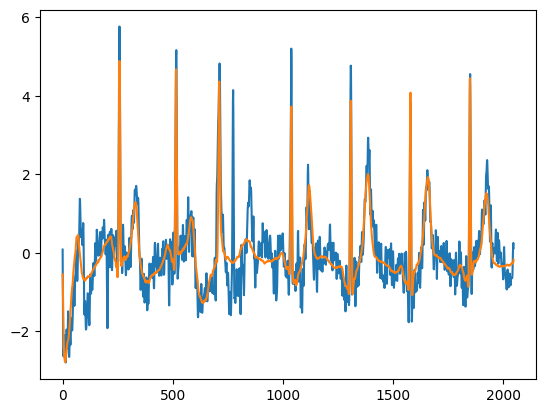

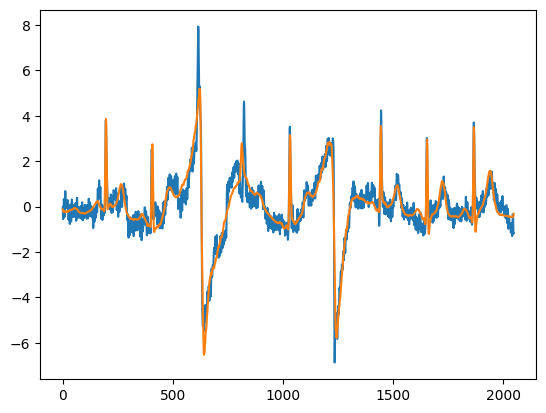

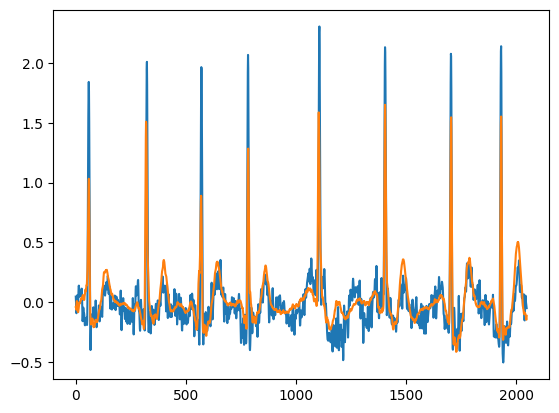

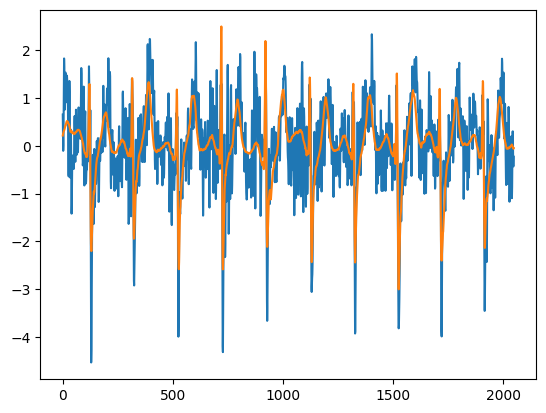

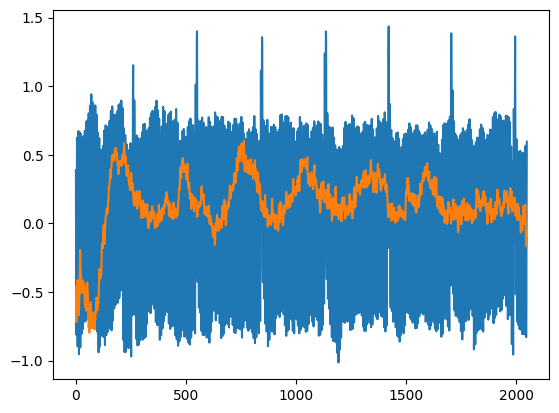

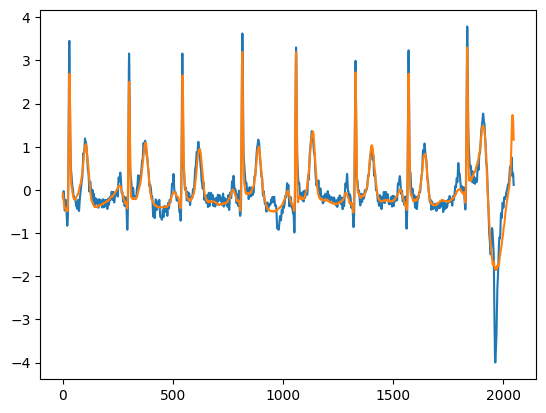

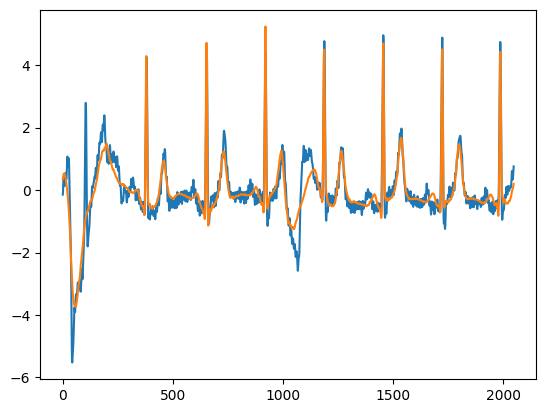

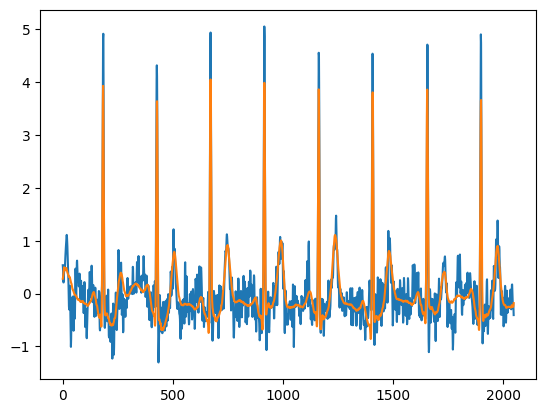

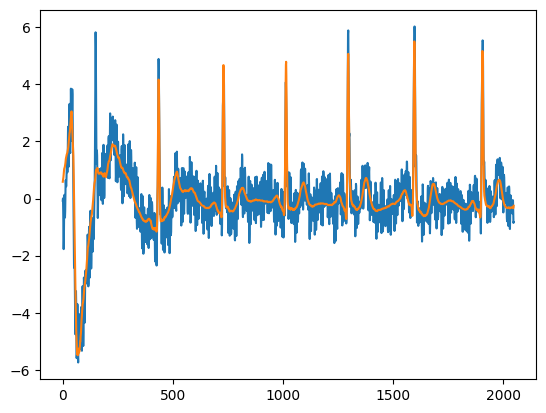

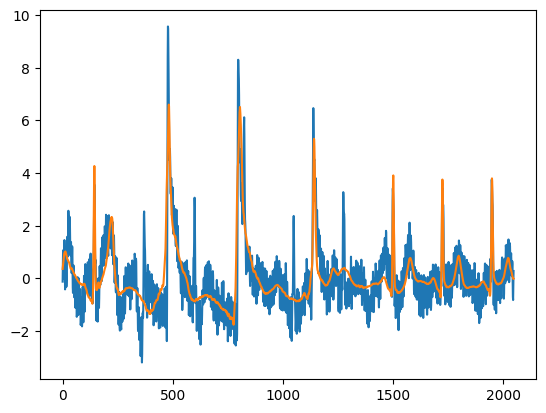

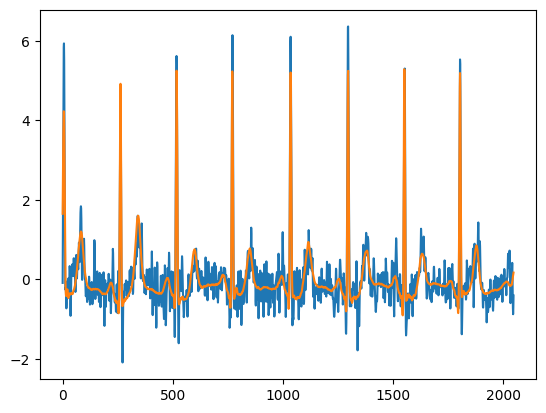

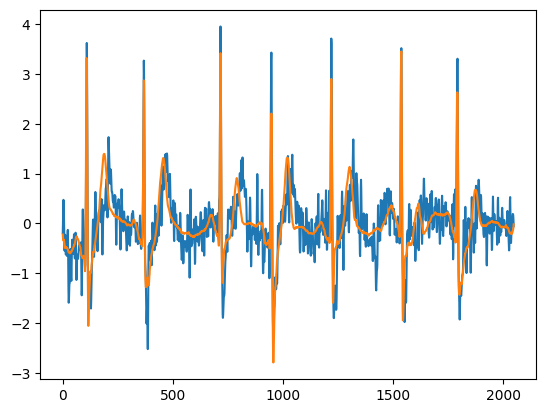

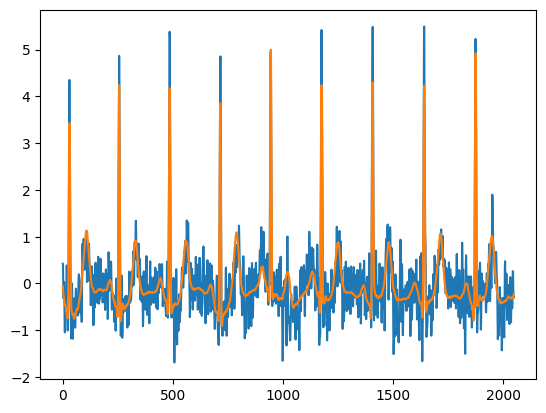

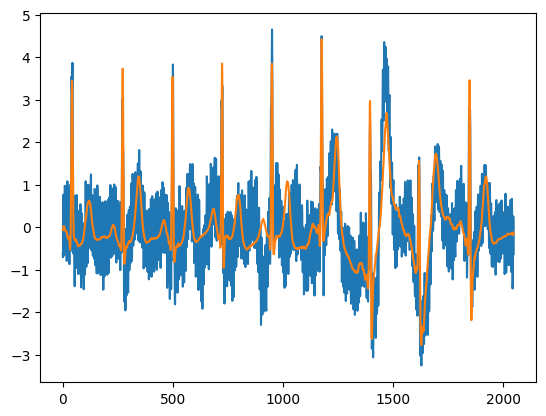

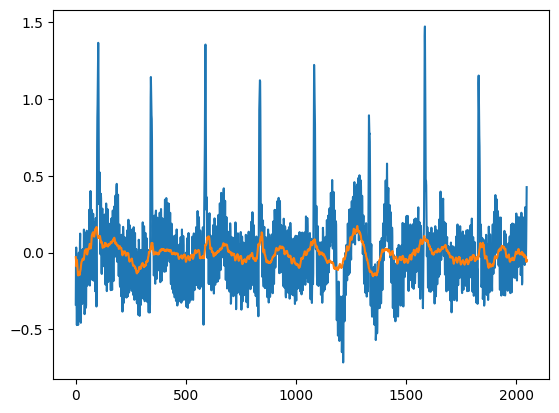

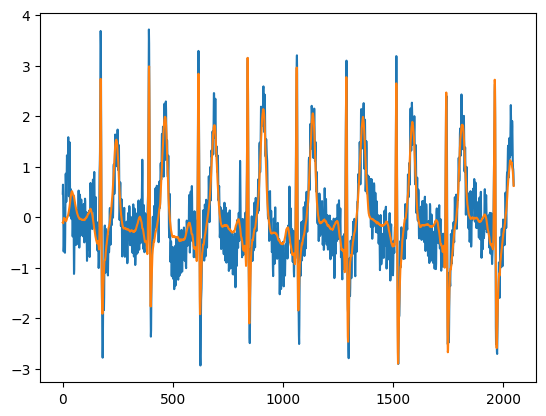

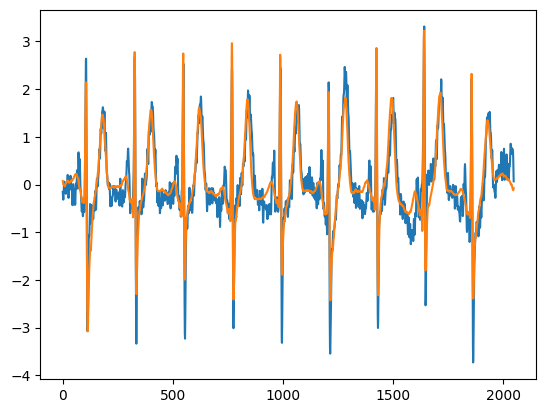

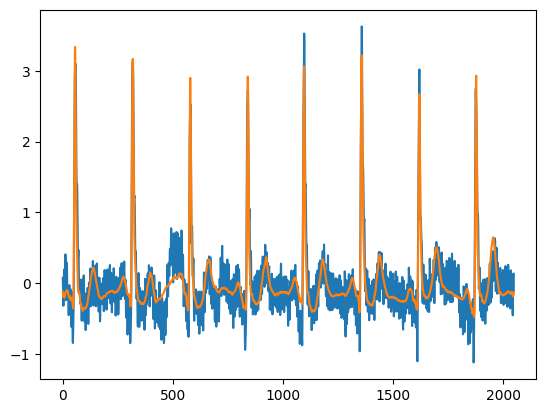

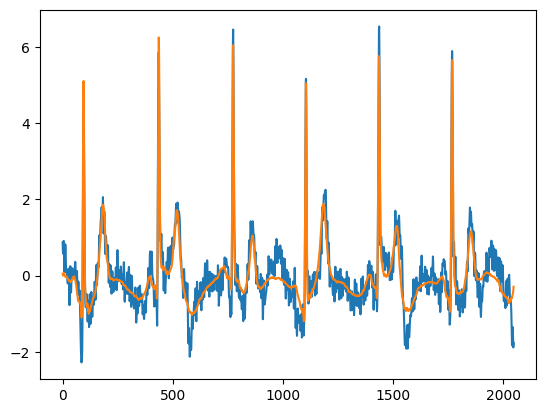

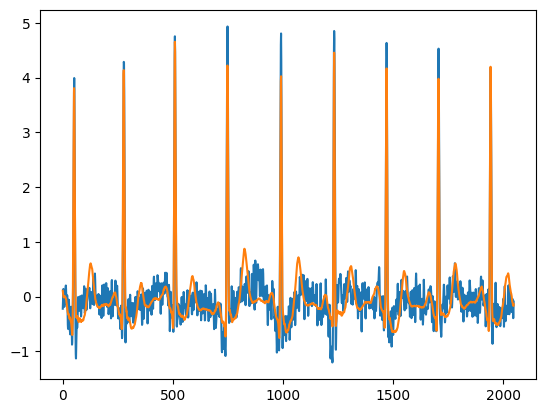

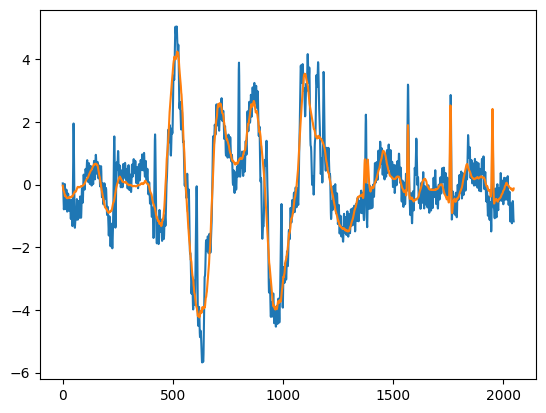

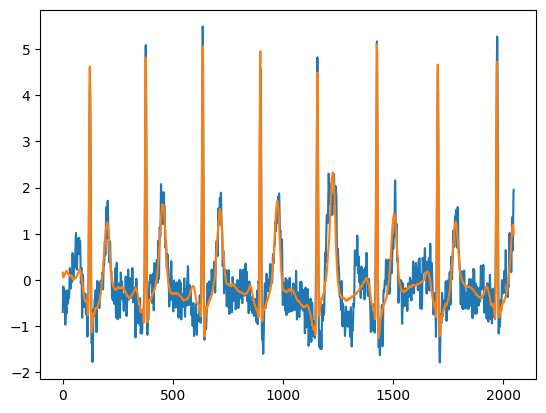

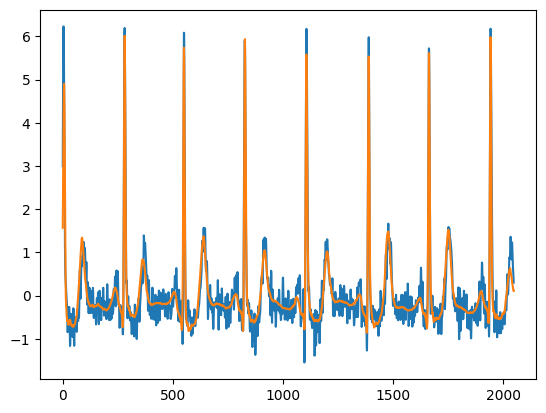

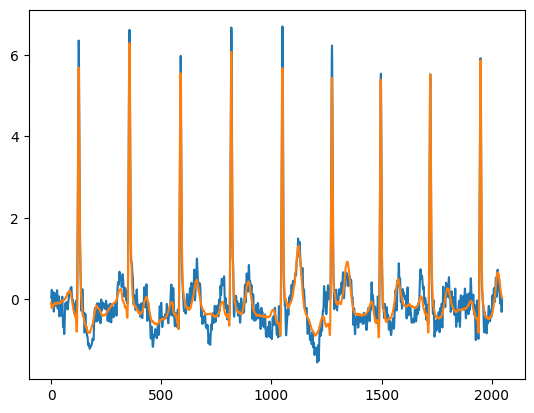

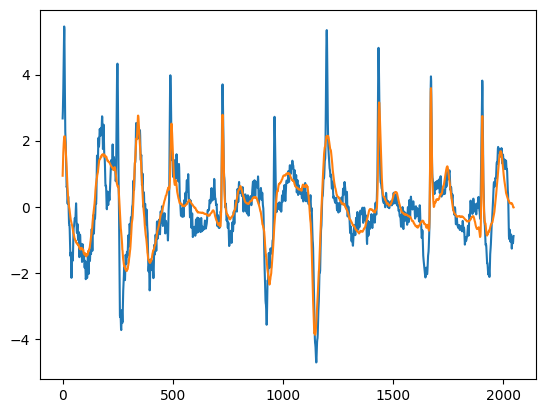

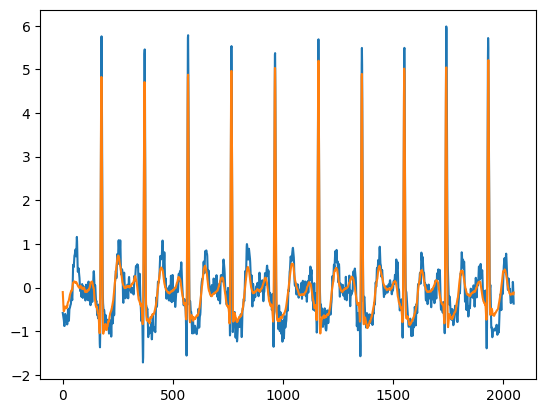

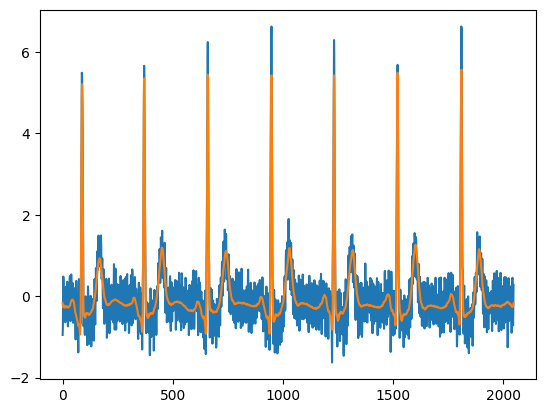

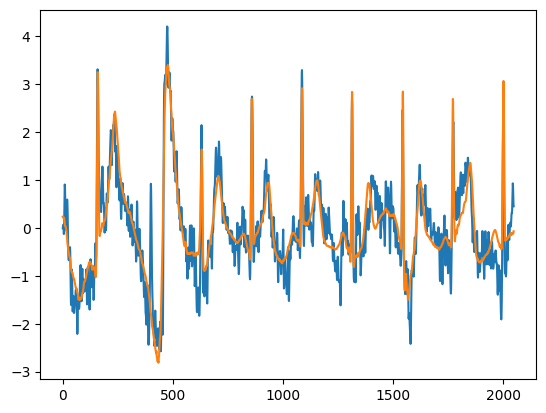

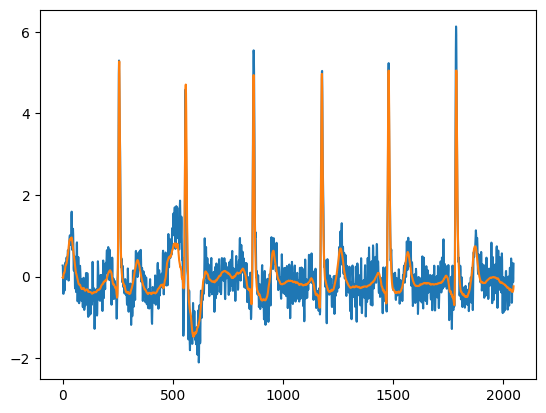

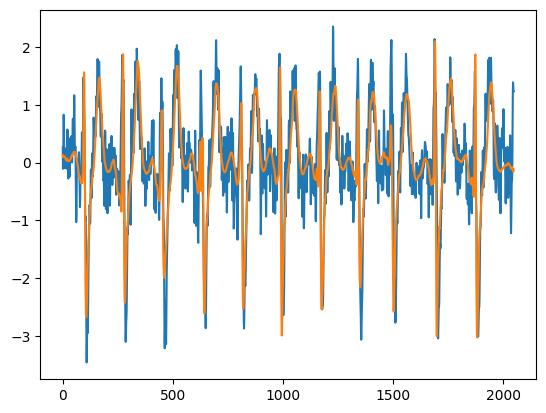

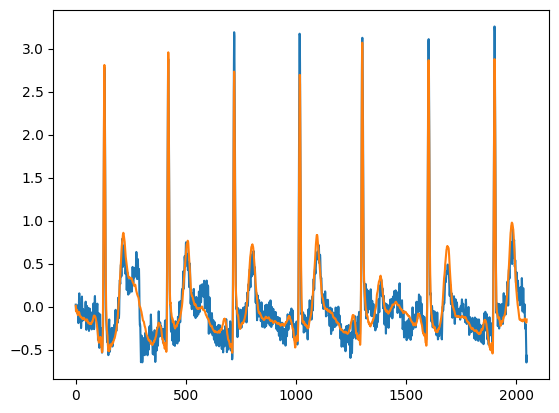

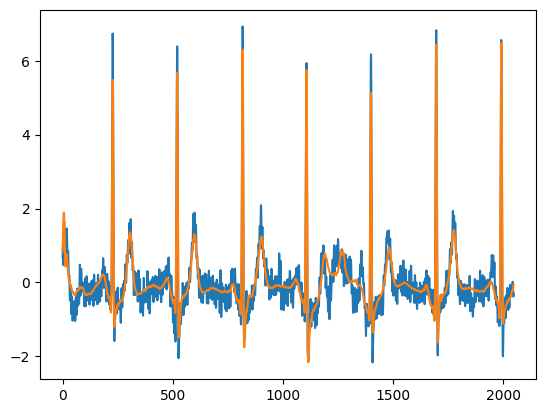

In [16]:
for i in range(32):
    plt.plot(signals_np[i, 0])
    plt.plot(output[i, 0])
    plt.show()

### Reconstruction for noisy samples

In [18]:
# Try on some noisy samples

noisy_dataset = Dataset(split_to_segments(test_dataset[test_dataset["class_index"] == 1], 2048, 9000, 0))
noisy_dataloader = DataLoader(noisy_dataset, batch_size=32, shuffle=True, pin_memory=True)

with torch.no_grad():
    model.eval()
    for i, (signals, _) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        output= model(signals)[0].detach().cpu().numpy()
        signals_np = signals.detach().cpu().numpy()

        break

        loss = loss_func(output, signals)
        test_loss += float(loss)

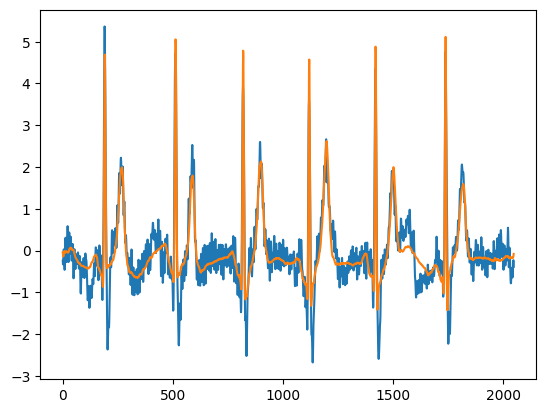

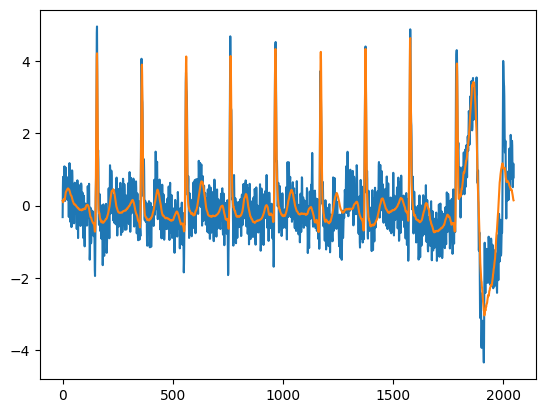

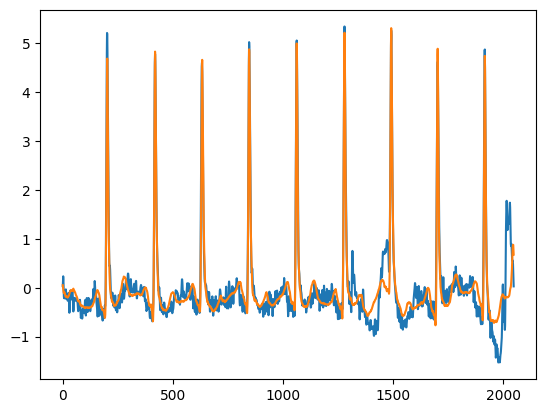

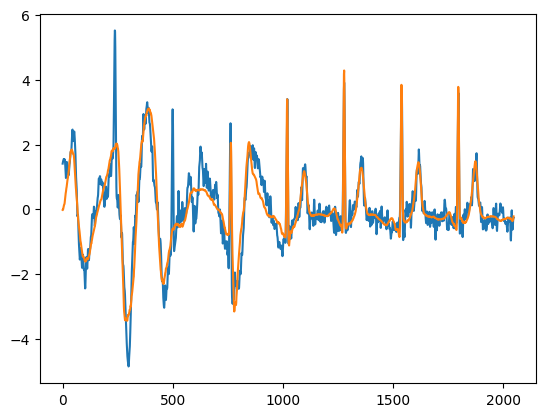

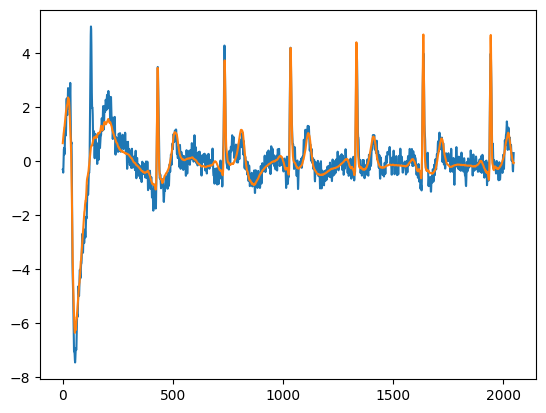

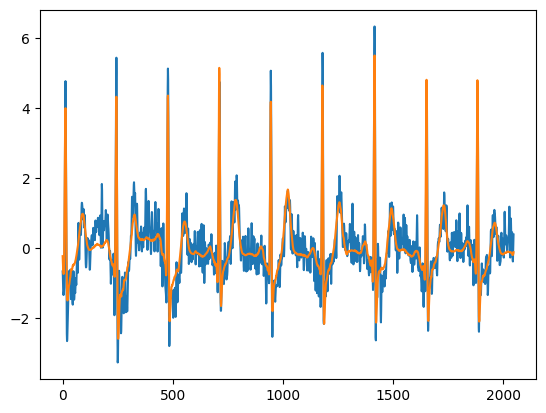

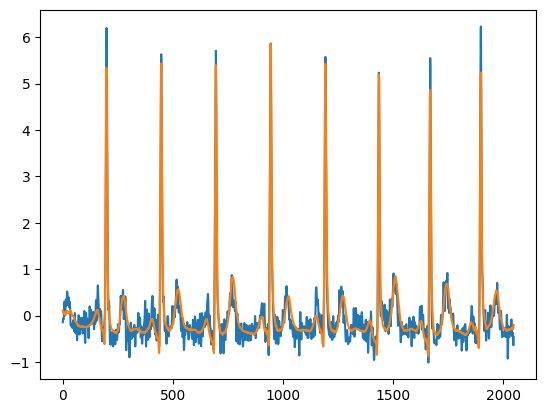

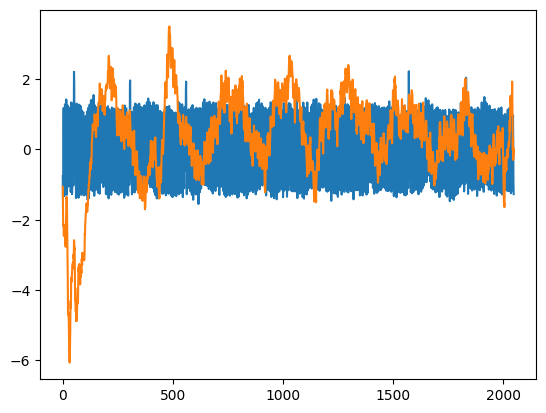

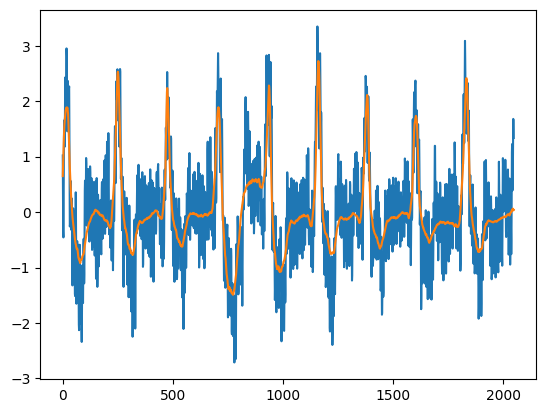

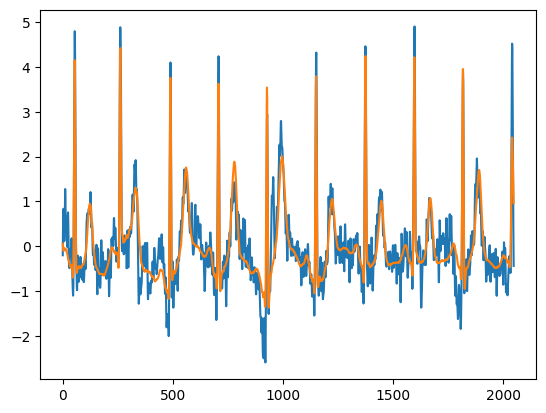

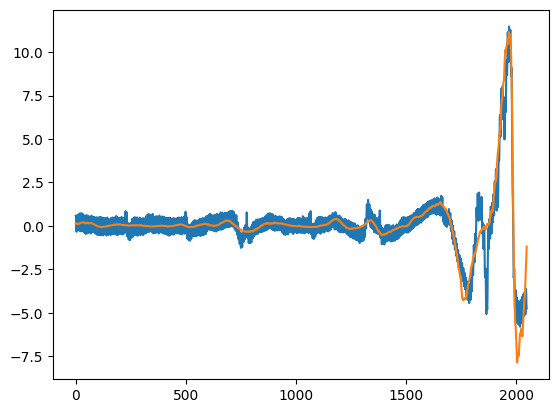

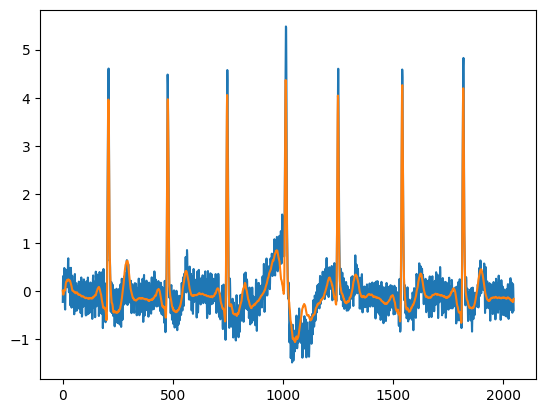

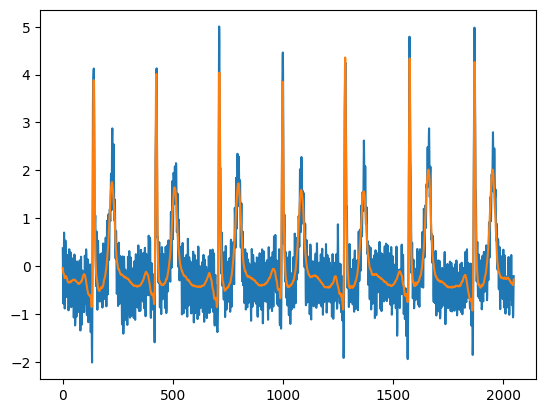

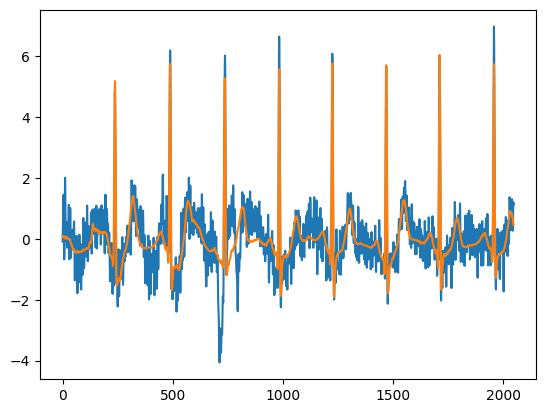

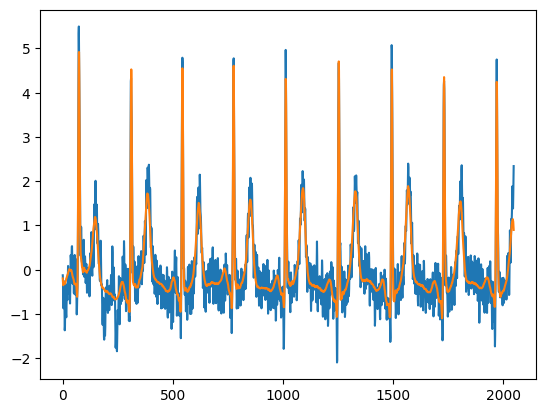

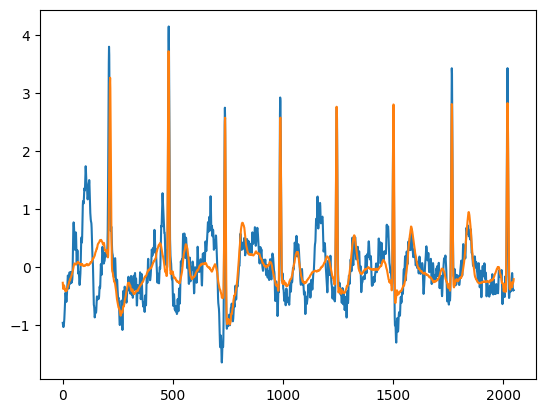

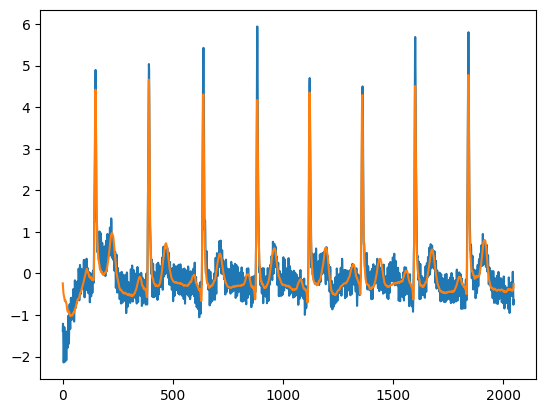

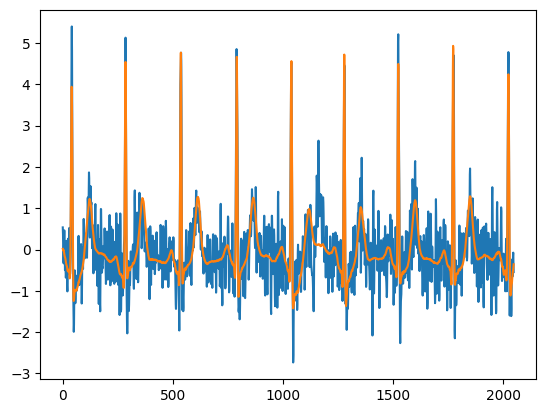

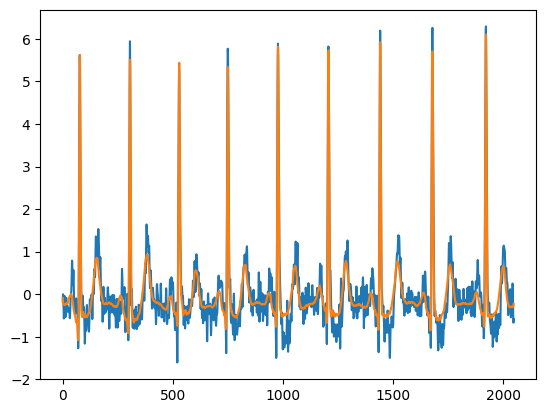

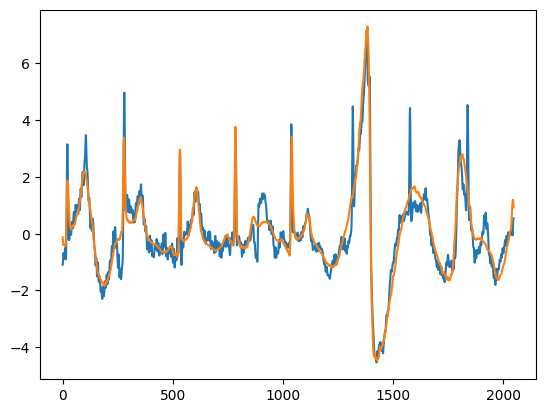

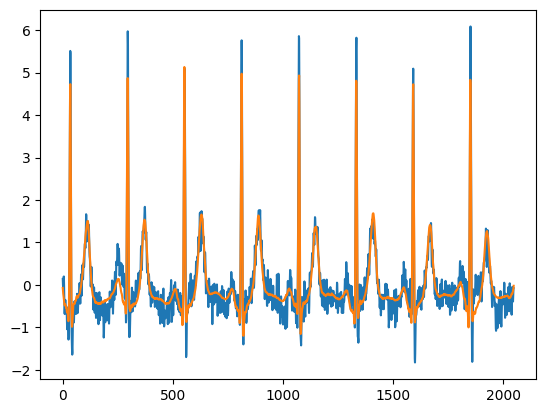

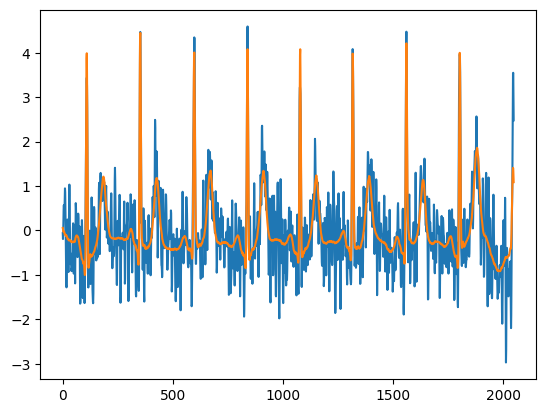

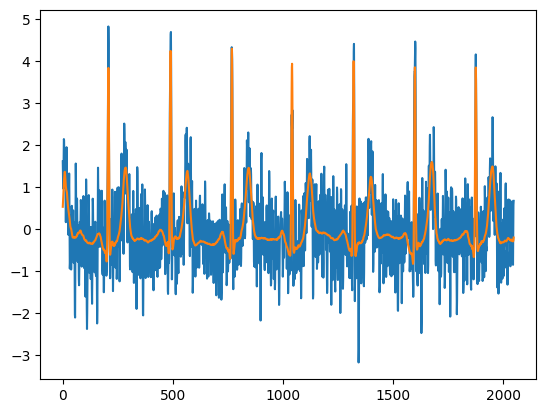

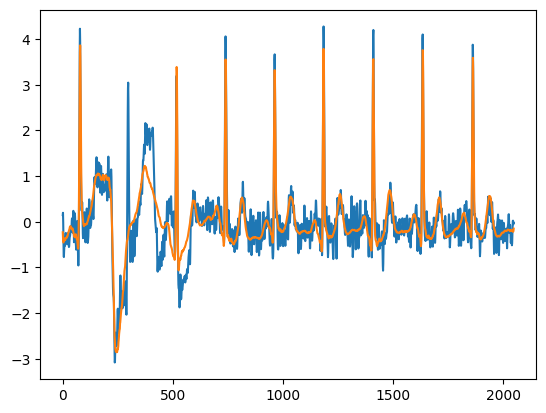

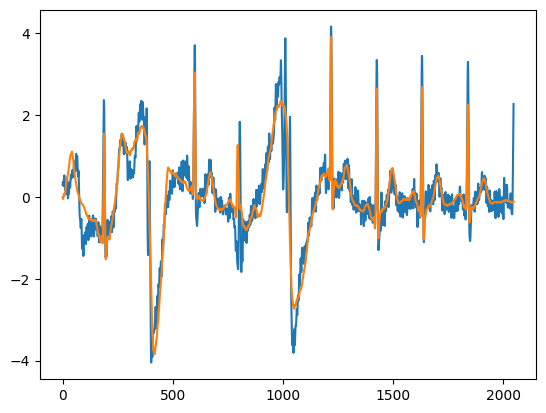

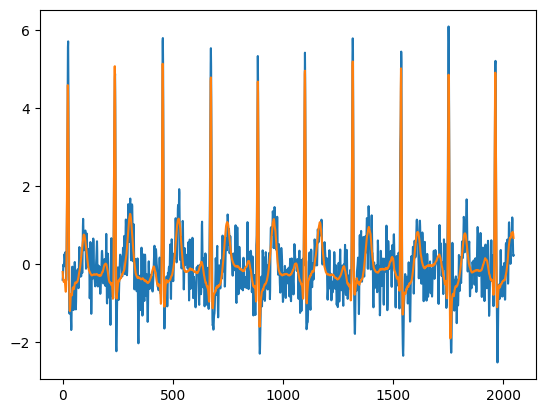

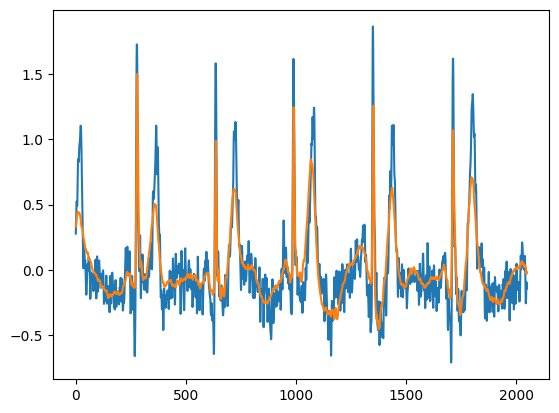

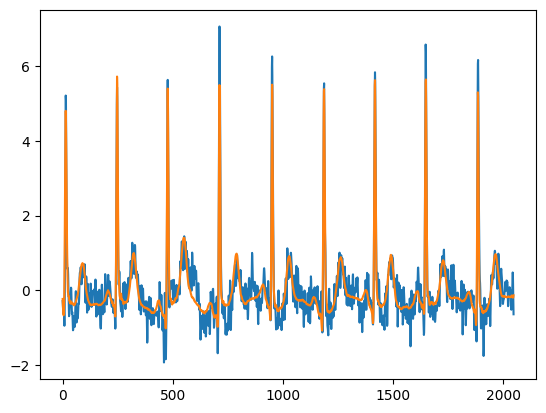

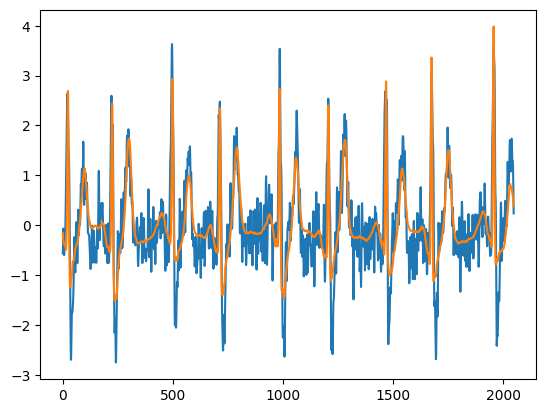

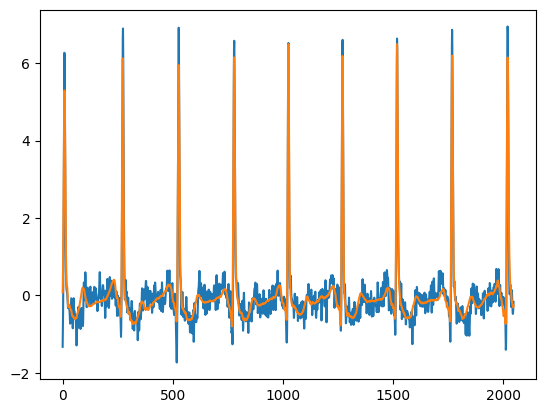

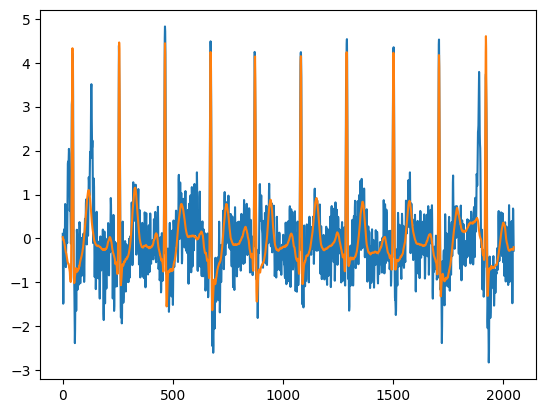

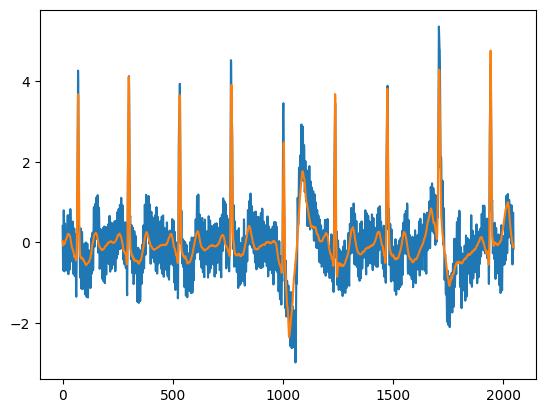

In [19]:
for i in range(32):
    plt.plot(signals_np[i, 0])
    plt.plot(output[i, 0])
    plt.show()

### Latent space exploration

In [26]:
# Try some latent space exploration

with torch.no_grad():
    model.eval()
    for i, (signals, _) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        latent_position = model.encode(signals)
        latent_position = latent_position.detach().cpu().numpy()
        signals_np = signals.detach().cpu().numpy()

        print(latent_position.shape)

        break

index = 3
latent_positions = np.zeros((10, *latent_position.shape), dtype=np.float32)
for i in range(10):
    latent_positions[i, :, :] += latent_position
    latent_positions[i, :, index] = i * 4 - 2

signals = []

with torch.no_grad():
    model.eval()
    for l in latent_positions:
        latent = torch.from_numpy(l[:, :60]).to(device)
        signal = model.decode(latent)
        signals.append(signal.detach().cpu().numpy())

(32, 120)


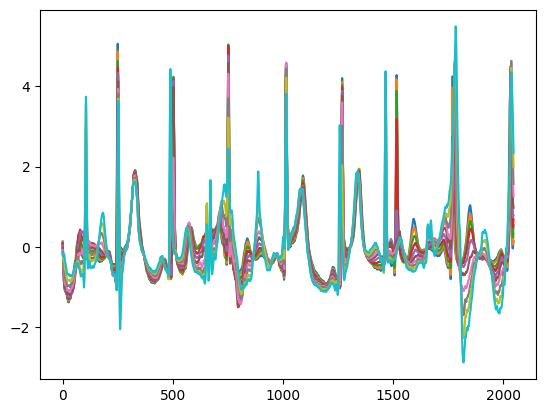

In [27]:
signals = np.array(signals)

for i in range(10):
    plt.plot(signals[:, 0, 0, :].T)
    plt.show()
    break

### Find the reconstruction error for noisy and clean samples

In [33]:
loss_func = torch.nn.MSELoss()

test_reconstruct_err = {"class_index" : [], "r_err": []}

with torch.no_grad():
    model.eval()
    for i, (signals, ci) in enumerate(test_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        # labels = labels.type(torch.LongTensor)

        output = model(signals)[0]
        signals_np = signals

        loss = loss_func(output, signals).detach().cpu().numpy()
        test_reconstruct_err["class_index"].append(ci[0])
        test_reconstruct_err["r_err"].append(loss)


  class_index       r_err
0   tensor(0)  0.24376619
1   tensor(0)   0.3385613
2   tensor(0)   0.3820357
3   tensor(0)  0.34183106
4   tensor(0)  0.21856424


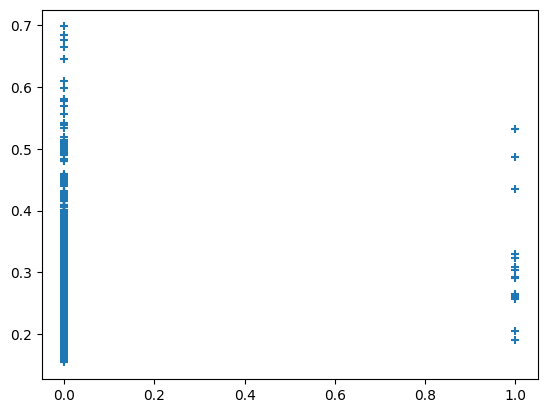

In [34]:
test_reconstruct_err = pd.DataFrame(data=test_reconstruct_err)
print(test_reconstruct_err.head())

plt.scatter(test_reconstruct_err["class_index"], test_reconstruct_err["r_err"], marker='+')
plt.show()

# What, it constructs the noisy samples better?
